In [60]:
from bs4 import BeautifulSoup
from requests import get

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

import time
import re
import os
from pathlib import Path

Some constants...

In [54]:
DATA_DIR = 'data'
GRAPH_FILENAME = 'wiki_graph'

# we filter out these types of link selectors
CLEAN = [
  'a[id="top"]',
  'a[class="mw-selflink selflink"]',
  'a[class="image"]',
  'a[class="internal"]',
]

# we filter out these links
REM_LINKS = [
  r"(\/wiki\/File:\w+)",
  r"(\/wiki\/Special:\w+)",
  r"(\/wiki\/Template:\w+)",
  r"(\/wiki\/Category:\w+)",
  r"(\/wiki\/Portal:\w+)",
  r"(\/wiki\/Template_talk:\w+)",
  r"(\/wiki\/Help:\w+)",
  r"(\/wiki\/Wikipedia:\w+)",
  r"(^#\w+)",
]

# main page content selector
CONT_SEL = "div#content"

In [55]:
# perform necessary cleaup to go from page name to formated title
def get_title(page):
  return re.sub(r"\/", "_", page)

Here, we load the list of pages that we are interested in scraping

In [56]:
# load most popular wikipedia pages csv
df = pd.read_csv(f"{DATA_DIR}/top1000.csv")

# get a list of pages as an array of strings
urls = df['article'].to_numpy().astype(str)

# filter the pages to only articles without ':' in the title
# I know this may not cover everything, but I'm just testing here
urls = urls[np.char.find(urls, ':') == -1]

# Download the Pages Locally

In [57]:
# in case you wanna skip ahead
START_INDEX = 960
SLEEP_TIME_S = 2 # dont make less than 2, we dont wanna overwhelm wikipedia too much

n = urls.size

for i, url in enumerate(urls):
  if i < START_INDEX:
    continue

  print(f"{i} of {n} ({round((i / n) * 100, 2)}%) - Scraping {url}")

  # load the page as html with BeautifulSoup
  res = get(f'https://en.wikipedia.org/wiki/{url}')

  # check if we got baned :c
  if res.status_code != 200:
    print("We got got")
    break

  html = BeautifulSoup(res.text, 'html.parser')

  # save html page as string
  html_str = str(html.prettify())

  # replace bad characters in titles with underscores
  title = get_title(url)

  # save file
  f = open(f"{DATA_DIR}/pages/{title}.html", "w")
  f.write(html_str)
  f.close()

  # let's not overload wikipedia with requests here
  time.sleep(SLEEP_TIME_S)

960 of 970 (98.97%) - Scraping Jimmy_Carter
961 of 970 (99.07%) - Scraping Bruce_Willis_filmography
962 of 970 (99.18%) - Scraping 1337x
963 of 970 (99.28%) - Scraping Sue_Bird
964 of 970 (99.38%) - Scraping Monaco
965 of 970 (99.48%) - Scraping West_Side_Story_(1961_film)
966 of 970 (99.59%) - Scraping Battle_of_Kharkiv_(2022)
967 of 970 (99.69%) - Scraping Patrick_Swayze
968 of 970 (99.79%) - Scraping Sweden
969 of 970 (99.9%) - Scraping Salman_Khan


# Building the Graph

In [69]:
files = os.scandir(path = f"./{DATA_DIR}/pages/")
n = len(list(files))

In [70]:
G = nx.DiGraph()

# list our downloaded files
files = os.scandir(path = f"./{DATA_DIR}/pages/")
# n = len(list(files))

for i, file in enumerate(files):
  # extract url from filename
  url = Path(file).stem

  print(f"{i} of {n} ({round((i / n) * 100, 2)}%) - Graphing {url}")

  # add the current page to the graph
  G.add_node(url)

  # load the page into memory
  f = open(file, "r")
  html = BeautifulSoup(f.read(), 'html.parser')
  f.close()

  # clean up unwanted elements from page
  for c in CLEAN:
    els = html.select(f"{CONT_SEL} {c}")
    for el in els:
      el.decompose()

  # further remove unwanted links
  links = html.select(f"{CONT_SEL} a")
  for link in links:
    # extract href from link
    href = link['href']

    # we are only interested in links that start with `/wiki/` and aren't in REM_LINKS
    if not any([re.match(regex, href) for regex in REM_LINKS]) and re.match(r"^\/wiki\/\w+", href):
      # extract href from link
      href = link['href']

      # this is the destination url
      url_ = re.sub(r"\/wiki\/", "", href)

      # we only add the destination url if it happens to be inside our links of interests
      if url_ in urls:
        # add edge to graph
        G.add_edge(url, url_)

  # save our graph at other file
  if i % 3 == 0:
    nx.write_gml(G, f"{DATA_DIR}/{GRAPH_FILENAME}.gml")

0 of 10 (0.0%) - Graphing 1337x
1 of 10 (10.0%) - Graphing Battle_of_Kharkiv_(2022)
2 of 10 (20.0%) - Graphing Bruce_Willis_filmography
3 of 10 (30.0%) - Graphing Jimmy_Carter
4 of 10 (40.0%) - Graphing Monaco
5 of 10 (50.0%) - Graphing Patrick_Swayze
6 of 10 (60.0%) - Graphing Salman_Khan
7 of 10 (70.0%) - Graphing Sue_Bird
8 of 10 (80.0%) - Graphing Sweden
9 of 10 (90.0%) - Graphing West_Side_Story_(1961_film)


# Displaying the Graph

In [74]:
print(G.number_of_nodes(), G.number_of_edges())

205 279


/tmp/ipykernel_63623/3064791202.py:40: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


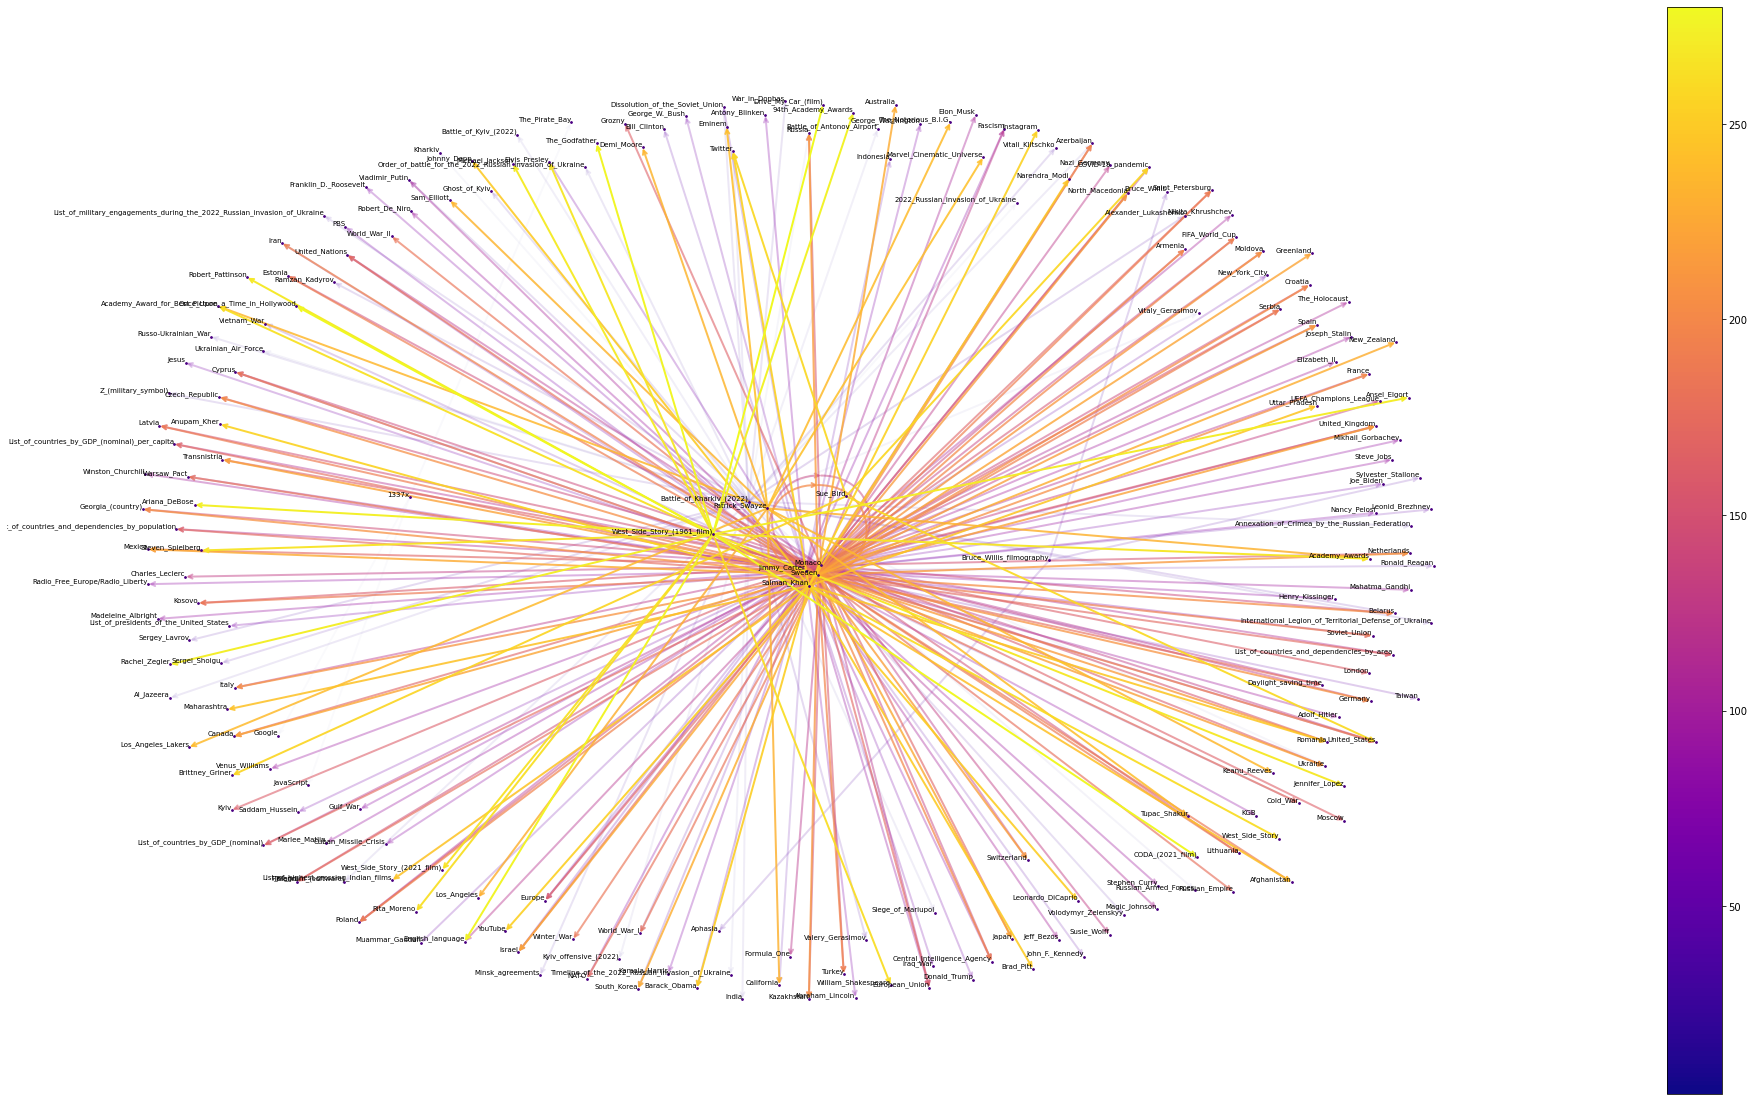

In [79]:
seed = 1337 # visual seed

# this spring layout allows us to position each edge in the graph, the seed simply ensures that the picture stays consistent
pos = nx.spring_layout(G, seed = seed)

# nodes are drawn different sizes based on importance
node_sizes = [3 + 10 * i for i in range(len(G))]
node_sizes = 3

M = G.number_of_edges()

# edge colors and alpha values are determined based on relation strength of nodes
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

# make our figure really large
plt.figure(3,figsize=(35,20)) 

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes ,node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
nx.draw_networkx_labels(G, pos, font_size=7, horizontalalignment='right', verticalalignment='bottom')

# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

# set colorbar on the side
pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()